In [6]:
import numpy as np
import pylab as plt # matplotlib
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from scipy import signal
import pyabf

import jax.numpy as jnp
import jax 
from jax import jit , lax

def read_abf_arr(path):
    abf = pyabf.ABF(path)
    print(abf)
    # plot the first channel
    abf.setSweep(sweepNumber=0, channel=0)
    time = abf.sweepX
    ampl= abf.sweepY

    # plot the second channel
    abf.setSweep(sweepNumber=0, channel=1)
    trigger = abf.sweepY
    return np.array([time,ampl,trigger])



#  Code used to plot the grating responses

In [7]:
# load grating response data
path = '20230721_0007_gratings.abf'
gratings1 = read_abf_arr(path)
path = '20230721_0009_gratings.abf'
gratings2 = read_abf_arr(path)

path = '20230721_0011_gratings.abf'
gratings4 = read_abf_arr(path)
path = '20230721_0013_gratings.abf'
gratings5 = read_abf_arr(path)


ABF (v2.9) with 2 channels (mV, V), sampled at 10.0 kHz, containing 1 sweep, having no tags, with a total length of 1.68 minutes, recorded with protocol "noise_arena".
ABF (v2.9) with 2 channels (mV, V), sampled at 10.0 kHz, containing 1 sweep, having no tags, with a total length of 1.63 minutes, recorded with protocol "noise_arena".
ABF (v2.9) with 2 channels (mV, V), sampled at 10.0 kHz, containing 1 sweep, having no tags, with a total length of 1.73 minutes, recorded with protocol "noise_arena".
ABF (v2.9) with 2 channels (mV, V), sampled at 10.0 kHz, containing 1 sweep, having no tags, with a total length of 1.59 minutes, recorded with protocol "noise_arena".


totel number of samples 1005056
number of samples after downsampling = 6030
totel number of samples 975872
number of samples after downsampling = 5855
totel number of samples 1040384
number of samples after downsampling = 6242
totel number of samples 952832
number of samples after downsampling = 5716
totel number of samples 1005056
number of samples after downsampling = 6030
totel number of samples 975872
number of samples after downsampling = 5855
totel number of samples 1040384
number of samples after downsampling = 6242
totel number of samples 952832
number of samples after downsampling = 5716
totel number of samples 1005056
number of samples after downsampling = 6030
totel number of samples 975872
number of samples after downsampling = 5855
totel number of samples 1040384
number of samples after downsampling = 6242
totel number of samples 952832
number of samples after downsampling = 5716
totel number of samples 1005056
number of samples after downsampling = 6030
totel number of sa

Text(0.5, 0, 'Time [s]')

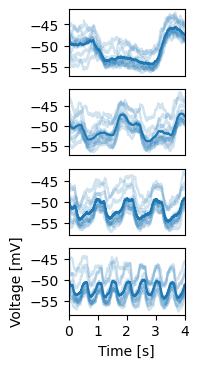

In [8]:
%matplotlib inline
plt.figure(figsize =(1.5,5))
plt.subplot(2,1,1)


def analyze_grating(grating,trigger,signal_length=10):
    ampl = grating[1]
    time = grating[0]
    trig = grating[2]
    framerate = 60
    
    trigger_val = 0.015

    samples = framerate*signal_length
    temp_samples = int(1.1*framerate)


    print("totel number of samples",len(time))
    n = len(time)
    n1 = int(n/10000*framerate)
    print("number of samples after downsampling =",n1)

    v_sig,t = signal.resample(ampl, n1*4, t=time, axis=0, window=None, domain='time')
    low_sig,low_t = signal.resample(v_sig, int(signal_length), t=t, axis=0, window=None, domain='time')
    low_sig2,low_t2 = signal.resample(low_sig, n1*4, t=low_t, axis=0, window=None, domain='time')
    trig_sig,t_trig = signal.resample(trig, n1*4, t=time, axis=0, window=None, domain='time')
    
    data = trig_sig
    mask1 = (data[:-1] < trigger_val) & (data[1:] > trigger_val)
    mask2 = (data[:-1] > trigger_val) & (data[1:] < trigger_val)

    timepoints = np.flatnonzero(mask1 | mask2)+1
    timepoints =timepoints/240
    difftime = np.zeros_like(timepoints)
    for i in range (len(timepoints)-1):
        difftime[i] = timepoints[i+1]-timepoints[i]

    pos = (np.array(np.where((difftime>signal_length-0.1)&(difftime<signal_length+0.11)))).astype(int)
    #print(pos)
    #print(timepoints[pos[0]])
    triggerpoints = timepoints[pos[0]]

    #print(triggerpoints[trigger])
    view_t= t[int(triggerpoints[trigger]*240):int(triggerpoints[trigger]*240+signal_length*240)]
    view_sig = v_sig[int(triggerpoints[trigger]*240):int(triggerpoints[trigger]*240+signal_length*240)]
    view_trig= trig_sig[int(triggerpoints[trigger]*240):int(triggerpoints[trigger]*240+signal_length*240)]

    return(np.array([view_t[0:signal_length*240],view_sig[0:signal_length*240],view_trig[0:signal_length*240]]))



for i in range(4): #iterate over 4 files
    plt.subplot(5,1,i+1)                    

    grating1_0 = analyze_grating(gratings1,i+1,12)    
    grating2_0 = analyze_grating(gratings2,i+1,12)
    grating4_0 = analyze_grating(gratings4,i+1,12)    
    grating5_0 = analyze_grating(gratings5,i+1,12)

    time0 =4/60*(-11.5+1)
    time_vals = np.linspace(0,12,len(grating1_0[0,0:2880]))

    plt.plot(time_vals[0:960],grating1_0[1,0:960],c="tab:blue", alpha = 0.2)    # trail1
    plt.plot(time_vals[0:960],grating1_0[1,960:1920],c="tab:blue", alpha = 0.2) # trail2
    plt.plot(time_vals[0:960],grating1_0[1,1920:2880],c="tab:blue", alpha = 0.2)# trail3
    plt.plot(time_vals[0:960],grating2_0[1,0:960],c="tab:blue", alpha = 0.2)    # trail4
    plt.plot(time_vals[0:960],grating2_0[1,960:1920],c="tab:blue", alpha = 0.2) # trail5
    plt.plot(time_vals[0:960],grating2_0[1,1920:2880],c="tab:blue", alpha = 0.2)# trail6

    plt.plot(time_vals[0:960],grating4_0[1,0:960],c="tab:blue", alpha = 0.2)    # trail7
    plt.plot(time_vals[0:960],grating4_0[1,960:1920],c="tab:blue", alpha = 0.2) # trail8
    plt.plot(time_vals[0:960],grating4_0[1,1920:2880],c="tab:blue", alpha = 0.2)# trail9
    plt.plot(time_vals[0:960],grating5_0[1,0:960],c="tab:blue", alpha = 0.2)    # trail10
    plt.plot(time_vals[0:960],grating5_0[1,960:1920],c="tab:blue", alpha = 0.2) # trail11
    plt.plot(time_vals[0:960],grating5_0[1,1920:2880],c="tab:blue", alpha = 0.2)# trail12
    
    mean = (grating1_0[:,0:2880]+grating2_0[:,0:2880]+grating4_0[:,0:2880]+grating5_0[:,0:2880])/4 #mean trail
    mean4 = (mean[1,960:1920]+mean[1,0:960]+mean[1,1920:2880])/3 #mean trail
    plt.plot(time_vals[0:960],mean4,c="tab:blue", alpha = 1)     #mean trail
    plt.xlim(0,4)
    plt.xticks([])    

plt.xticks([0,1,2,3,4])
plt.ylabel("Voltage [mV]")

plt.xlabel("Time [s]")

#use to save as pdf
#import matplotlib as mpl
#mpl.rcParams['pdf.fonttype'] = 42       
#plt.savefig('MI9_Grating_Analysis.pdf')
#plt.tight_layout()

# code used to plot edge responses

ABF (v2.9) with 2 channels (mV, V), sampled at 10.0 kHz, containing 1 sweep, having no tags, with a total length of 0.72 minutes, recorded with protocol "noise_arena".
totel number of samples 430080
number of samples after downsampling = 2580
-0.008683962003304057
0.03658009066271304
[[4]]
[3.8917]
3.8916666666666666
totel number of samples 430080
number of samples after downsampling = 2580
-0.008683962003304057
0.03658009066271304
[[10]]
[18.45]
18.45
totel number of samples 430080
number of samples after downsampling = 2580
-0.008683962003304057
0.03658009066271304
[[16]]
[26.9958]
26.995833333333334
totel number of samples 430080
number of samples after downsampling = 2580
-0.008683962003304057
0.03658009066271304
[[22]]
[32.5417]
32.541666666666664
ABF (v2.9) with 2 channels (mV, V), sampled at 10.0 kHz, containing 1 sweep, having no tags, with a total length of 0.79 minutes, recorded with protocol "noise_arena".
totel number of samples 474112
number of samples after downsampling =

Text(0.5, 0, 'Azimuth [°]')

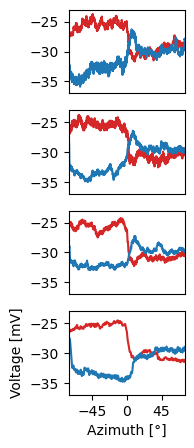

In [9]:
%matplotlib inline
plt.figure(figsize =(1.5,5))

def analyze_grating(grating,trigger,signal_length=10):
    ampl = grating[1]
    time = grating[0]
    trig = grating[2]
    framerate = 60
    
    trigger_val = 0.015

    samples = framerate*signal_length
    temp_samples = int(1.1*framerate)


    print("totel number of samples",len(time))
    n = len(time)
    n1 = int(n/10000*framerate)
    print("number of samples after downsampling =",n1)

    v_sig,t = signal.resample(ampl, n1*4, t=time, axis=0, window=None, domain='time')
   
    trig_sig,t_trig = signal.resample(trig, n1*4, t=time, axis=0, window=None, domain='time')
    
    print(np.amin(trig_sig))
    print(np.amax(trig_sig))


    data = trig_sig
    mask1 = (data[:-1] < trigger_val) & (data[1:] > trigger_val)
    mask2 = (data[:-1] > trigger_val) & (data[1:] < trigger_val)

    timepoints = np.flatnonzero(mask1 | mask2)+1
    timepoints =timepoints/240
    difftime = np.zeros_like(timepoints)
    for i in range (len(timepoints)-1):
        difftime[i] = timepoints[i+1]-timepoints[i]

    pos = (np.array(np.where((difftime>signal_length-0.1)&(difftime<signal_length+0.11)))).astype(int)

    #print(timepoints[pos:pos+2])
    print(pos)
    print(timepoints[pos[0]])
    triggerpoints = timepoints[pos[0]]

    print(triggerpoints[trigger])
    view_t= t[int(triggerpoints[trigger]*240):int(triggerpoints[trigger]*240+signal_length*240)]
    view_sig = v_sig[int(triggerpoints[trigger]*240):int(triggerpoints[trigger]*240+signal_length*240)]
    view_trig= trig_sig[int(triggerpoints[trigger]*240):int(triggerpoints[trigger]*240+signal_length*240)]

    return(np.array([view_t,view_sig,view_trig]))


path = '20230718_0012_ONedges_15-120_0-30-0.abf'

gratings4 = read_abf_arr(path)


edge1_0 = analyze_grating(gratings4,0,12)
edge1_1 = analyze_grating(gratings4,0,6)
edge1_2 = analyze_grating(gratings4,0,3)
edge1_3 = analyze_grating(gratings4,0,1.5)



path = '20230718_0013_ONedges_15-120_0-30-0.abf'

gratings4 = read_abf_arr(path)


edge2_0 = analyze_grating(gratings4,0,12)
edge2_1 = analyze_grating(gratings4,0,6)
edge2_2 = analyze_grating(gratings4,0,3)
edge2_3 = analyze_grating(gratings4,0,1.5)

path = '20230718_0014_ONedges_15-120_0-30-0.abf'

gratings4 = read_abf_arr(path)


edge3_0 = analyze_grating(gratings4,0,12)
edge3_1 = analyze_grating(gratings4,0,6)
edge3_2 = analyze_grating(gratings4,0,3)
edge3_3 = analyze_grating(gratings4,0,1.5)


edge0_all = (edge1_0+edge2_0+edge3_0)/3
edge1_all = (edge1_1+edge2_1+edge3_1)/3
edge2_all = (edge1_2+edge2_2+edge3_2)/3
edge3_all = (edge1_3+edge2_3+edge3_3)/3

path = '20230718_0015_OFFedges_15-120_0-30-0.abf'

gratings4 = read_abf_arr(path)


edge1_0_off = analyze_grating(gratings4,0,12)
edge1_1_off = analyze_grating(gratings4,0,6)
edge1_2_off = analyze_grating(gratings4,0,3)
edge1_3_off = analyze_grating(gratings4,0,1.5)

path = '20230718_0016_OFFedges_15-120_0-30-0.abf'

gratings4 = read_abf_arr(path)


edge2_0_off = analyze_grating(gratings4,0,12)
edge2_1_off = analyze_grating(gratings4,0,6)
edge2_2_off = analyze_grating(gratings4,0,3)
edge2_3_off = analyze_grating(gratings4,0,1.5)

path = '20230718_0017_OFFedges_15-120_0-30-0.abf'

gratings4 = read_abf_arr(path)


edge3_0_off = analyze_grating(gratings4,0,12)
edge3_1_off = analyze_grating(gratings4,0,6)
edge3_2_off = analyze_grating(gratings4,0,3)
edge3_3_off = analyze_grating(gratings4,0,1.5)

edge0_off_all = (edge1_0_off+edge2_0_off+edge3_0_off)/3
edge1_off_all = (edge1_1_off+edge2_1_off+edge3_1_off)/3
edge2_off_all = (edge1_2_off+edge2_2_off+edge3_2_off)/3
edge3_off_all = (edge1_3_off+edge2_3_off+edge3_3_off)/3



xaxis =np.linspace(-90+15,90+15,len(edge0_all[1]))
plt.subplot(4,1,1)
plt.plot(xaxis,edge0_all[1],c="tab:red")
plt.plot(xaxis,edge0_off_all[1],c="tab:blue")
plt.xlim(-75,75)
plt.yticks([-35,-30,-25])
plt.ylim(-37,-23)
plt.xticks([])

xaxis =np.linspace(-90+15,90+15,len(edge1_all[1]))
plt.subplot(4,1,2)
plt.plot(xaxis,edge1_all[1],c="tab:red")
plt.plot(xaxis,edge1_off_all[1],c="tab:blue")
plt.xlim(-75,75)
plt.yticks([-35,-30,-25])
plt.ylim(-37,-23)
plt.xticks([])
         
xaxis =np.linspace(-90+15,90+15,len(edge2_all[1]))
plt.subplot(4,1,3)
plt.plot(xaxis,edge2_all[1],c="tab:red")
plt.plot(xaxis,edge2_off_all[1],c="tab:blue")
plt.xlim(-75,75)
plt.yticks([-35,-30,-25])
plt.ylim(-37,-23)
plt.xticks([])

xaxis =np.linspace(-90+15,90+15,len(edge3_all[1]))
plt.subplot(4,1,4)
plt.plot(xaxis,edge3_all[1],c="tab:red")
plt.plot(xaxis,edge3_off_all[1],c="tab:blue")
plt.xlim(-75,75)
plt.ylim(-37,-23)
plt.yticks([-35,-30,-25])
plt.xlim(-75,75)
plt.xticks([-45,0,45])

plt.ylabel("Voltage [mV]")

plt.xlabel("Azimuth [°]")

#import matplotlib as mpl
#mpl.rcParams['pdf.fonttype'] = 42       
#plt.savefig('MI9_Edge_Analysis.pdf')

# Code used to plot receptive fields

0.26020493868506694
1.0


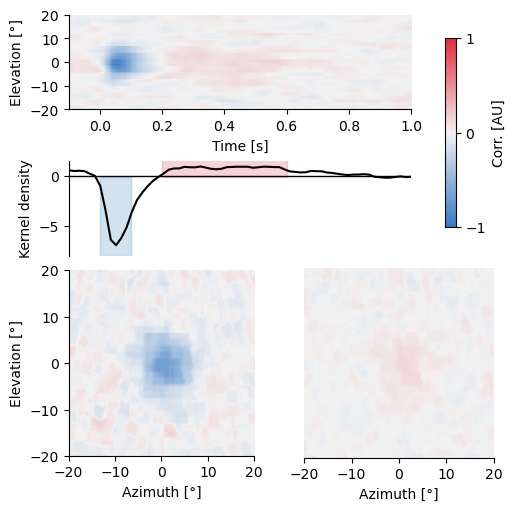

In [10]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import seaborn as sns

cmap = sns.diverging_palette(250,10, 85,50,center ="light", as_cmap=True)

arr = np.load("r_Mi9_avg_imgs_bin1.npy")
arr2 = np.load("r_Mi9_avg_imgs_bin2.npy")
arr3 = np.load("r_Mi9_avg_imgs_bin3.npy")

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline
combined = (arr+arr2+arr3)/3

print(combined.std())
combined = combined/abs(combined).max()

fig = plt.figure(figsize=(5, 5), layout="constrained")
spec = fig.add_gridspec(4, 6)

right = fig.add_subplot(spec[0, :-1])

img=right.imshow(combined[:,:,355:365].mean(axis=2).T,cmap = cmap,extent=[-0.1,1,-90,90],vmin =-1,vmax = 1,aspect='auto')#,interpolation='bicubic')
right.set_ylim(-20,20)
#right.yaxis.tick_right()
#right.yaxis.set_label_position("right")
right.set_xlabel("Time [s]")
right.set_ylabel("Elevation [°]")
right.set_yticks([-20,-10,0,10,20])
right.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
#right.set_yticks([])
right.set_xlim(-0.1,1)

right.spines['top'].set_visible(False)
right.spines['right'].set_visible(False)
#right1.spines['bottom'].set_visible(False)
#right.spines['left'].set_visible(False)

right1 = fig.add_subplot(spec[1, :-1])

ycoord = np.linspace(-0.1,1,len(combined[:,0,0]))
impulse_resp = combined[:,175:185,355:365].mean(axis=(1,2))/((abs(combined[:,175:185,355:365].mean(axis=(1,2)))).mean())

print(abs(impulse_resp).mean())
right1.plot(ycoord,impulse_resp,color = "black")#,interpolation='bicubic')
right1.set_ylim(-8,1.5)
right1.axvspan(0, 0.1,0,25/30,alpha=0.2, color='tab:blue')
right1.axvspan(0.2, 0.6,25/30,30,alpha=0.2, color='tab:red')

#right1.yaxis.tick_right()
#right1.yaxis.set_label_position("right")
#right1.set_ylabel("time [s]")
right1.set_ylabel("Kernel density")
#right1.set_xticks([-20,-10,0,10,20])
#right1.set_yticks([-100,0,100,200,300,400,500,600,700,800,900,1000])
right1.set_xticks([])
right1.set_xlim(-0.1,1)
right1.spines['top'].set_visible(False)
right1.spines['right'].set_visible(False)
right1.spines['bottom'].set_visible(False)
#right1.spines['left'].set_visible(False)
right1.hlines(0,-0.1,1,color ="black",linewidth = 1)

leftup = fig.add_subplot(spec[2:4, 0:3])

leftup.imshow(combined[6:12].mean(axis=0),extent=[-180,180,-90,90],cmap=cmap,vmin =-1, vmax = 1)
leftup.set_xlim(-20,20)
leftup.set_xticks([-20,-10,0,10,20])
leftup.set_yticks([-20,-10,0,10,20])
leftup.set_ylim(-20,20)
leftup.set_ylabel("Elevation [°]")
leftup.set_xlabel("Azimuth [°]")
leftup.spines['top'].set_visible(False)
leftup.spines['right'].set_visible(False)

leftdown = fig.add_subplot(spec[2:4, 3:6])

leftdown.imshow(combined[18:42].mean(axis=0),extent=[-180,180,-90,90],cmap=cmap,vmin =-1, vmax = 1)
leftdown.set_xlim(-20,20)
leftdown.set_ylim(-20,20)
leftdown.set_xticks([-20,-10,0,10,20])
#leftdown.set_yticks([-20,-10,0,10,20])
leftdown.set_yticks([])
#leftdown.set_ylabel("elevation [°]")
leftdown.set_xlabel("Azimuth [°]")
leftdown.spines['top'].set_visible(False)
leftdown.spines['right'].set_visible(False)
leftdown.spines['left'].set_visible(False)

axins = inset_axes(right1, # here using axis of the lowest plot
               width="3%",  # width = 5% of parent_bbox width
               height="200%",  # height : 340% good for a (4x4) Grid
               loc='lower left',
               bbox_to_anchor=(1.10, 0.3, 1, 1),
               bbox_transform=right1.transAxes,
               borderpad=0,
               )

cb = fig.colorbar(img, cax=axins,ticks=[-1, 0, 1],label ="Corr. [AU]")

#import matplotlib as mpl
#mpl.rcParams['pdf.fonttype'] = 42       
#plt.savefig('MI9_RF_Analysis.pdf')